In [19]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
%matplotlib inline
from nilearn import plotting
from nilearn import image as nli
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
import re

## Understanding our data
### fMRI imaging subject phenotypic information

In [20]:
# p = r"/media/nap-smasher/My Passport/malis-autism-project/brain_img/"
# with_fmri = []
# for subj in sub_list:
#     if os.path.exists(p+subj+"/session_1/rest_1/rest.nii.gz") or os.path.exists(p+subj+"/session_1/func/rest.nii.gz"):
#         with_fmri.append(subj)
# with open("preprocessing/with_func.txt", "w") as f:
#     f.writelines("\n".join(with_fmri))

In [21]:
with open("../preprocessing/subj_list.txt", "r") as f:
    sub_list = f.read().splitlines()

has_fmri_path = "../preprocessing/with_func.txt"
with open(has_fmri_path) as f:
    has_fmri = f.read().splitlines()

csv_path = "../ABIDEII/ABIDEII_Composite_Phenotypic.csv"
df_pheno = pd.read_csv(csv_path, encoding="unicode_escape")

info_processed_subjs = df_pheno[df_pheno['SUB_ID'].isin(list(map(int,sub_list)))][['SUB_ID','SEX','DX_GROUP','AGE_AT_SCAN ','FIQ']]

# check requirements
subjs_selection = info_processed_subjs[(info_processed_subjs['AGE_AT_SCAN '] <= 40) & (info_processed_subjs['FIQ'] >= 80) & (info_processed_subjs['SUB_ID'].isin(list(map(int,has_fmri))))][['SUB_ID','SEX','DX_GROUP']]

# mark for exclusion from the dataset for ML the subjects that don't satisfy the requirements
exclusion_list = list(set(sub_list) - set(map(str,subjs_selection['SUB_ID'])))
# with open("preprocessing/exclusion_list.txt", "x") as f:
#     f.writelines("\n".join(exclusion_list))

In [22]:
exclusion_list

['28713', '28712', '29622', '28711']

In [23]:
print(f'Number of subjects processed: {len(sub_list)}')
print(f'Number of subjects satisfying the requirements: {len(subjs_selection)}')
print(f'Total autistic: {len(subjs_selection[subjs_selection["DX_GROUP"] == 1])}')
print(f'Total controls: {len(subjs_selection[subjs_selection["DX_GROUP"] == 2])}')
print(f'Females autistic: {len(subjs_selection[(subjs_selection["SEX"] == 2) & subjs_selection["DX_GROUP"] == 1])}')
print(f'Males autistic: {len(subjs_selection[(subjs_selection["SEX"] == 1) & (subjs_selection["DX_GROUP"] == 1)])}')
print(f'Females control: {len(subjs_selection[(subjs_selection["SEX"] == 2) & (subjs_selection["DX_GROUP"] == 2)])}')
print(f'Males control: {len(subjs_selection[(subjs_selection["SEX"] == 1) & (subjs_selection["DX_GROUP"] == 2)])}')
print(f'Total females: {len(subjs_selection[subjs_selection["SEX"] == 2])}')
print(f'Total males: {len(subjs_selection[subjs_selection["SEX"] == 1])}')

Number of subjects processed: 420
Number of subjects satisfying the requirements: 416
Total autistic: 200
Total controls: 216
Females autistic: 61
Males autistic: 139
Females control: 156
Males control: 60
Total females: 217
Total males: 199


We wanted to have the same number of autistic and controls but apparently we counted something wrong earlier so it's not exactly 50/50.

## Computing correlation matrices from our processed fMRIs applying a Craddock Atlas

In [24]:
# data_path = r"/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/"
data_path = r"/media/nap-smasher/My Passport/preproc_bolds/"
subj_data_paths = os.listdir(data_path)
subj_ids_processed = [re.search(r"[0-9]{5}",p).group() for p in subj_data_paths]

labeled_subjs = {}
subj_sex = {}   # need this for testing model performance by sex
for p in subj_data_paths:
    sub_id = int(re.search(r"[0-9]{5}",p).group())
    # keep only those in subjs_selection
    if sub_id in list(subjs_selection['SUB_ID']):
        labeled_subjs[p] = int(df_pheno[df_pheno['SUB_ID']==sub_id]['DX_GROUP'])
        subj_sex[sub_id] = int(df_pheno[df_pheno['SUB_ID']==sub_id]['SEX'])

preproc_bolds = [nib.load(data_path+subj) for subj in labeled_subjs.keys()]

### Using atlas downloaded from nilearn: fewer ROIs than the one used by C-PAC
=> will produce fewer features

In [25]:
dataset = datasets.fetch_atlas_craddock_2012(data_dir="/home/nap-smasher/Documents/malis-project-autism/preprocessing", url=None, resume=True)
dataset.keys()

dict_keys(['description', 'scorr_mean', 'tcorr_mean', 'scorr_2level', 'tcorr_2level', 'random'])

There are 6 different flavors of Craddock atlas: we try to understand the differences

In [26]:
scorr_mean_atlas = nib.load(dataset['scorr_mean'])
print(scorr_mean_atlas.shape)
plot = plotting.plot_prob_atlas(scorr_mean_atlas)
# plot.savefig("final_report/img/atlas.png")

(47, 56, 46, 43)


In [27]:
# tcorr_mean_atlas = nib.load(dataset['tcorr_mean'])
# print(tcorr_mean_atlas.shape)
# plotting.plot_prob_atlas(tcorr_mean_atlas)

In [28]:
# scorr_2level_atlas = nib.load(dataset['scorr_2level'])
# print(scorr_2level_atlas.shape)
# plotting.plot_prob_atlas(scorr_2level_atlas)

In [29]:
# tcorr_2level_atlas = nib.load(dataset['tcorr_2level'])
# print(tcorr_2level_atlas.shape)
# plotting.plot_prob_atlas(tcorr_2level_atlas)

In [30]:
# random_atlas = nib.load(dataset['random'])
# print(random_atlas.shape)
# plotting.plot_prob_atlas(random_atlas)

We are not able to make an informed decision as to which atlas to use, so we arbitrarily choose the first one

## Applying scorr_mean_atlas

From here, following <a href="https://brainhack101.github.io/introML-book/01/MAIN_tutorial_machine_learning_with_nilearn.html">this tutorial</a>

In [31]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    scorr_mean_atlas, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


## Apply atlas to fMRIs
### Generate correlationn matrices
(next cell is commented out because it takes forever to execute: we then reimport the all_features vector from file to test the rest of the cells)

In [32]:
# all_features = []
# for i,sub in enumerate(preproc_bolds):
#     # extract the timeseries from the ROIs in the atlas
#     time_series = masker.transform(sub)
#     # create a region x region correlation matrix
#     correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#     # add to our container
#     all_features.append(correlation_matrix)
#     # keep track of status
#     print('finished %s of %s'%(i+1,len(preproc_bolds)))


In [33]:
# np.save('ABIDEII/data/labels', list(labeled_subjs.values()))
# np.savez_compressed('ABIDEII/data/features',x=all_features)
# np.save('ABIDEII/data/sex', list(subj_sex.values()))

Text(0, 0.5, 'subjects')

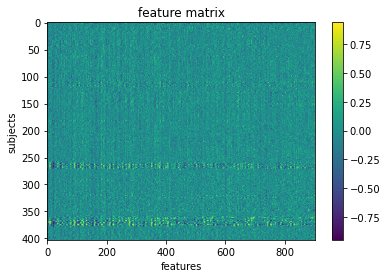

In [35]:
import matplotlib.pyplot as plt

all_features = np.load('../ABIDEII/data/features.npz')['x']
plt.imshow(all_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')


Text(0, 0.5, 'subjects')

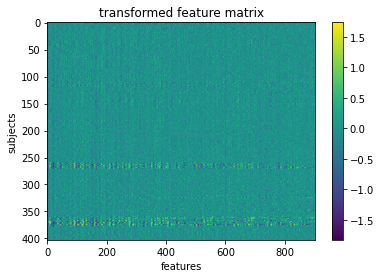

In [36]:
fisher_features = np.arctanh(all_features)
# np.savez_compressed("ABIDEII/data/features_transformed", x=fisher_features)
plt.imshow(fisher_features, aspect='auto')
plt.colorbar()
plt.title('transformed feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Plot an example correlation matrix for visualization

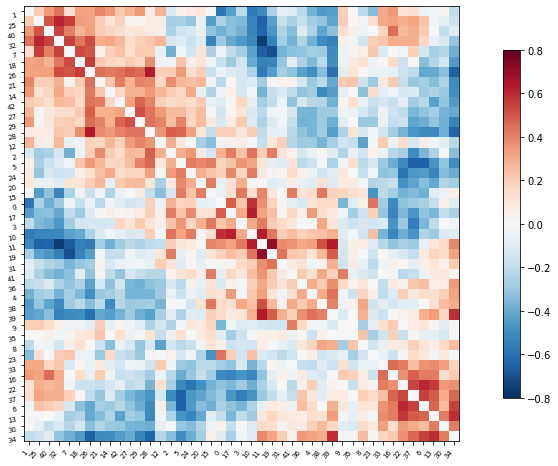

In [49]:
time_series = masker.transform(preproc_bolds[0])
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
# np.fill_diagonal(correlation_matrix,0)

plot = plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=np.arange(correlation_matrix.shape[0]),
                     vmax=0.8, vmin=-0.8, reorder=True, colorbar=True)
plot.figure.savefig("../final_report/img/corr_matrix.png")

**Apply Fisher transform and plot**

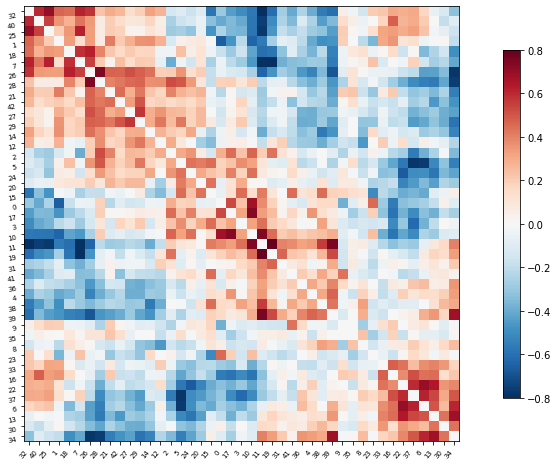

In [50]:
# np.fill_diagonal(correlation_matrix, 0)

transformed_matrix = np.arctanh(correlation_matrix)
plotting.plot_matrix(transformed_matrix, figure=(10, 8), labels=np.arange(correlation_matrix.shape[0]),
                     vmax=0.8, vmin=-0.8, reorder=True, colorbar=True)